In [1]:
import os
import tqdm
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

from models.network_nimbusr import NIMBUSR as net
from data.dataset_multiblur import Dataset

import utils.utils_image as util
import utils.utils_sisr as sisr

In [14]:
opt_net = { "n_iter": 8
        , "h_nc": 64
        , "in_nc": 4
        , "out_nc": 3
        , "ksize": 25
        , "nc": [64, 128, 256, 512]
        , "nb": 2
        , "gc": 32
        , "ng": 2
        , "reduction" : 16
        , "act_mode": "R" 
        , "upsample_mode": "convtranspose" 
        , "downsample_mode": "strideconv"}

opt_data = { "phase": "train"
          , "dataset_type": "usrnet_multiblur"
          , "dataroot_H": "datasets/COCO/val2014"
          , "dataroot_L": None
          , "H_size": 256
          , "use_flip": True
          , "use_rot": True
          , "scales": [2]
          , "sigma": [0, 2]
          , "sigma_test": 15
          , "n_channels": 3
          , "dataloader_shuffle": True
          , "dataloader_num_workers": 16
          , "dataloader_batch_size": 16
          , "motion_blur": True

          , "coco_annotation_path": "datasets/COCO/instances_val2014.json"}

In [15]:
path_pretrained = r'model_zoo/NIMBUSR.pth'

netG = net(n_iter=opt_net['n_iter'],
                   h_nc=opt_net['h_nc'],
                   in_nc=opt_net['in_nc'],
                   out_nc=opt_net['out_nc'],
                   nc=opt_net['nc'],
                   nb=opt_net['nb'],
                   act_mode=opt_net['act_mode'],
                   downsample_mode=opt_net['downsample_mode'],
                   upsample_mode=opt_net['upsample_mode']
                   )

netG.load_state_dict(torch.load(path_pretrained))
netG = netG.to('cuda')

In [16]:
data = Dataset(opt_data)

loading annotations into memory...
Done (t=5.33s)
creating index...
index created!


  0%|          | 0/10 [00:00<?, ?it/s]

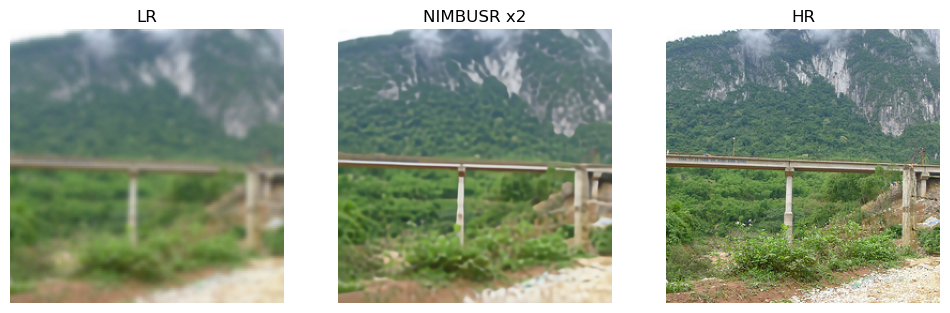

 10%|█         | 1/10 [00:00<00:08,  1.05it/s]

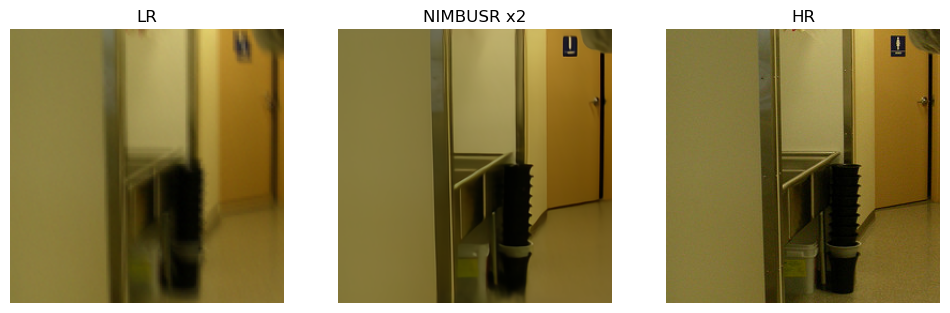

 20%|██        | 2/10 [00:02<00:07,  1.01it/s]

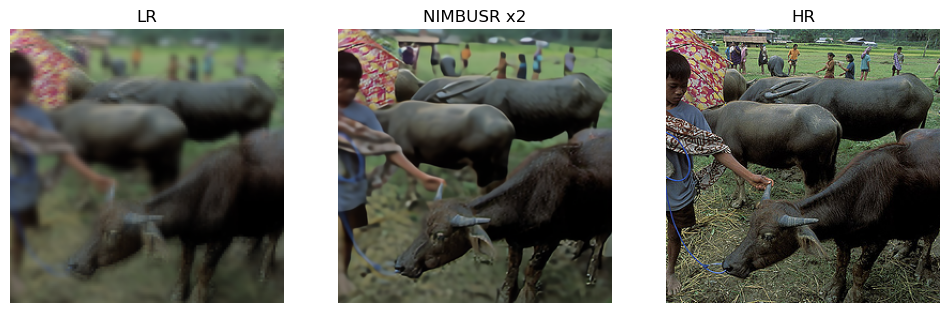

 30%|███       | 3/10 [00:04<00:09,  1.35s/it]

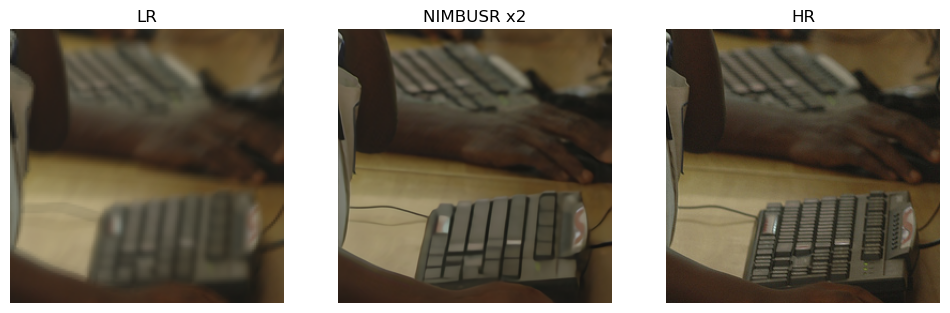

 40%|████      | 4/10 [00:05<00:08,  1.44s/it]

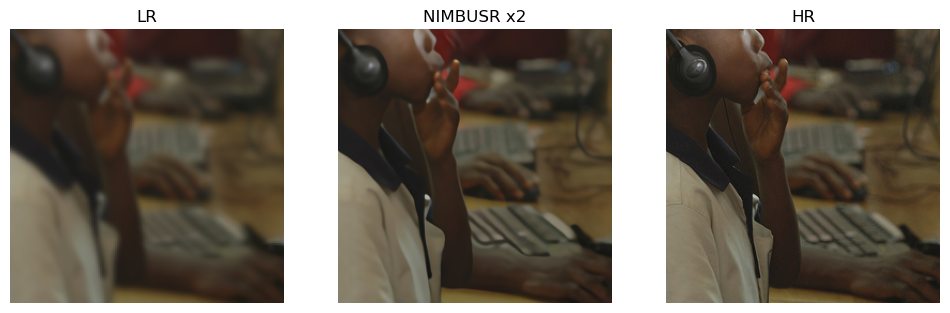

 50%|█████     | 5/10 [00:08<00:09,  1.86s/it]

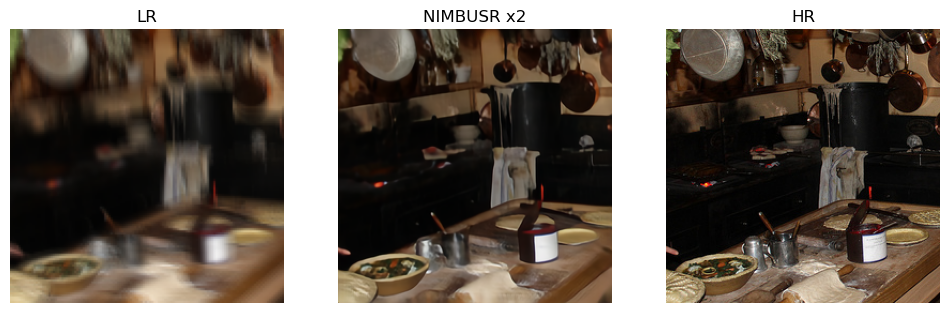

 60%|██████    | 6/10 [00:11<00:08,  2.03s/it]

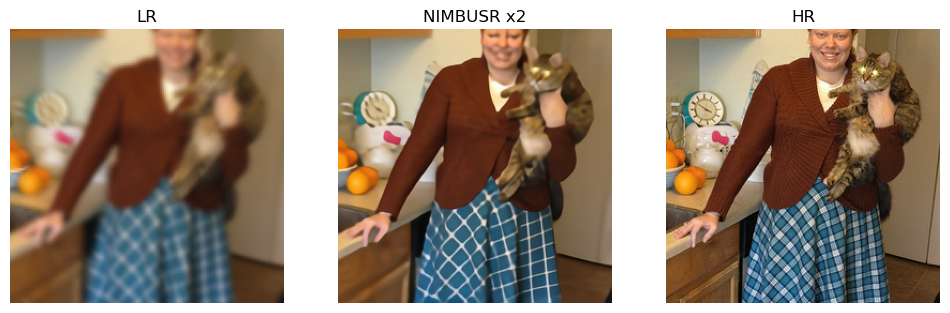

 70%|███████   | 7/10 [00:13<00:06,  2.25s/it]

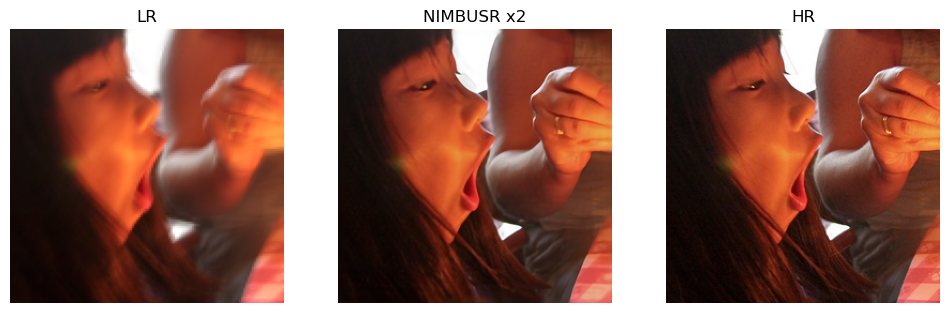

 80%|████████  | 8/10 [00:15<00:03,  1.93s/it]

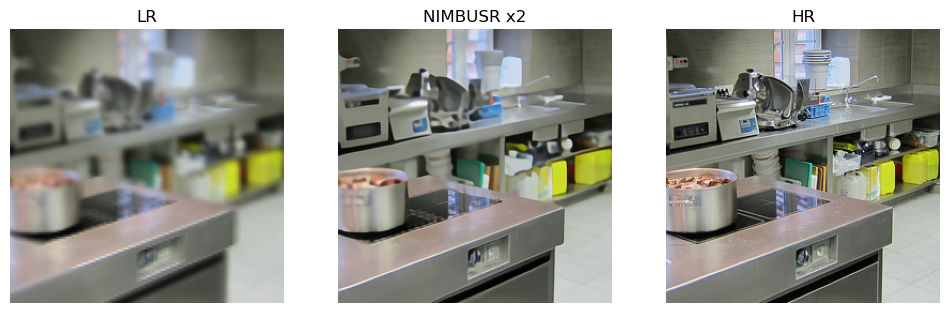

 90%|█████████ | 9/10 [00:16<00:01,  1.73s/it]

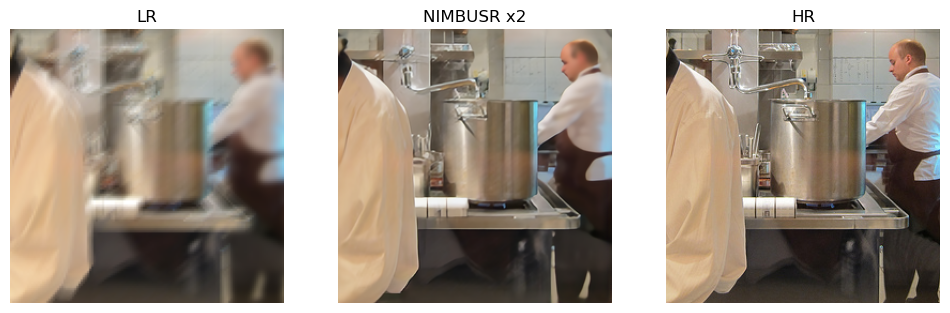

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [21]:
save_path = r'results/coco_testset'

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
if not os.path.isdir(os.path.join(save_path, 'HR')):
    os.mkdir(os.path.join(save_path, 'HR'))
    
if not os.path.isdir(os.path.join(save_path, 'LR')):
    os.mkdir(os.path.join(save_path, 'LR'))
    
if not os.path.isdir(os.path.join(save_path, 'NIMBUSR')):
    os.mkdir(os.path.join(save_path, 'NIMBUSR'))

for i in tqdm.tqdm(range(10)):
    sample = data[i]
    HR = util.tensor2uint(sample['H'])
    LR = util.tensor2uint(sample['L'])
    y = sample['L'][None].to('cuda')
    kmap = sample['kmap'][None].to('cuda')
    basis = sample['basis'][None].to('cuda')
    sf = sample['sf']
    sigma = sample['sigma'][None].to('cuda')
    
    res = netG(y, kmap, basis, sf, sigma)
    res = util.tensor2uint(res)
    
    util.imsave(HR, os.path.join(save_path, 'HR', str(i) + '.png'))
    util.imsave(LR, os.path.join(save_path, 'LR', str(i) + '.png'))
    util.imsave(res, os.path.join(save_path, 'NIMBUSR', str(i) + '.png'))
    
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(LR)
    plt.title('LR')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(res)
    plt.title('NIMBUSR x' + str(sf))
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(HR)
    plt.title('HR')
    plt.axis('off')
    plt.show()